# DogFaceNet Training

Esse arquivo contém:
 - Split dos Dataset
 - Carregamento do Dataset
 - Definição do Modelo
 - Treinamento do Modelo

In [1]:
%%capture
import os

current_dir = os.getcwd()
target_dir = os.path.join(current_dir, 'caramelo', 'dogfacenet')

if not current_dir.endswith('caramelo/dogfacenet'):
    !git clone https://github.com/UnB-CIS/caramelo.git -b dogFaceNet
    %cd caramelo/dogfacenet

### Imports

In [2]:
import tensorflow as tf
import os
import numpy as np
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image

# funcoes para o treinamento da triplet loss
from online_training import *

2025-09-02 22:32:36.495985: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756852356.701025      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756852356.756703      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Config

In [3]:
PATH        = '../data'                    # Path to the directory of the saved dataset
PATH_SAVE   = '../output/history/'          # Path to the directory where the history will be stored
PATH_MODEL  = '../output/model/2025.08.19/' # Path to the directory where the model will be stored
SIZE        = (224,224,3)                   # Size of the input images
TEST_SPLIT  = 0.1                           # Test ratio
VAL_SPLIT = 0.1                             # Validation ratio
TRAIN_SPLIT = 1 - (TEST_SPLIT + VAL_SPLIT)  # Train ratio

LOAD_NET    = False                         # Load a network from a saved model? If True NET_NAME and START_EPOCH have to be precised
NET_NAME    = '2025.08.19.dogfacenet'       # Network saved name
START_EPOCH = 0                             # Start the training at a specified epoch
NBOF_EPOCHS = 1                             # Number of epoch to train the network
STEPS_PER_EPOCH = 300                       # Number of steps per epoch
VALIDATION_STEPS = 30                       # Number of steps per validation

### Split e Carregamento dos Dados

In [4]:
import zipfile
import os

# Verifica se o diretório de dados já existe
if not os.path.exists(PATH):
    # Extrai data.zip para o diretório de dados
    with zipfile.ZipFile(PATH+'.zip', 'r') as zip_ref:
        zip_ref.extractall(PATH)
    print('Dados extraídos com sucesso!')
else:
    print('Diretório de dados já existe. Pulando extração.')

Dados extraídos com sucesso!


In [5]:
assert os.path.isdir(PATH), '[Erro] O caminho fornecido para o dataset não existe.'

# carrega o dataset
filenames = np.empty(0)
labels = np.empty(0)
idx = 0
for root,dirs,files in os.walk(PATH):
    if len(files)>1:
        for i in range(len(files)):
            files[i] = root + '/' + files[i]
        filenames = np.append(filenames,files)
        labels = np.append(labels,np.ones(len(files))*idx)
        idx += 1
assert len(labels)!=0, '[Erro] Nenhum dado fornecido.'

print('Total de imagens: {:d}'.format(len(labels)))

nbof_classes = len(np.unique(labels))
print('Total de classes: {:d}'.format(nbof_classes))

Total de imagens: 8363
Total de classes: 1393


In [6]:
nbof_train = int(TRAIN_SPLIT*nbof_classes)
nbof_val = int(VAL_SPLIT*nbof_classes)

# cria matrizes booleanas que indicam quais classes(cachorros) pertencem a qual split
keep_train = np.less(labels, nbof_train)
keep_val = np.logical_and(np.greater_equal(labels, nbof_train), np.less(labels, nbof_train + nbof_val))
keep_test = np.greater_equal(labels, nbof_train + nbof_val)

# seleciona arquivos pertencentes a cada split
filenames_train = filenames[keep_train]
labels_train = labels[keep_train]
filenames_test = filenames[keep_test]
labels_test = labels[keep_test]
filenames_val = filenames[keep_val]
labels_val = filenames[keep_val]

## Definindo o Modelo

In [7]:
# definindo a funcao de perda
alpha = 0.3
def triplet(y_true,y_pred):

    a = y_pred[0::3]
    p = y_pred[1::3]
    n = y_pred[2::3]

    ap = K.sum(K.square(a-p),-1)
    an = K.sum(K.square(a-n),-1)

    return K.sum(tf.nn.relu(ap - an + alpha))

def triplet_acc(y_true,y_pred):
    a = y_pred[0::3]
    p = y_pred[1::3]
    n = y_pred[2::3]

    ap = K.sum(K.square(a-p),-1)
    an = K.sum(K.square(a-n),-1)

    return K.less(ap+alpha,an)

In [8]:
if LOAD_NET:
    print('Loading model from {:s}{:s}.{:d}.h5 ...'.format(PATH_MODEL,NET_NAME,START_EPOCH))

    model = tf.keras.models.load_model(
        '{:s}{:s}.{:d}.h5'.format(PATH_MODEL,NET_NAME,START_EPOCH),
        custom_objects={'triplet':triplet,'triplet_acc':triplet_acc})

    print('Done.')
else:
    from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Add, GlobalAveragePooling2D # type: ignore
    from tensorflow.keras.layers import Dropout, Flatten, Dense, Lambda, BatchNormalization # type: ignore

    print('Defining model {:s} ...'.format(NET_NAME))

    emb_size = 32

    inputs = Input(shape=SIZE)

    x = Conv2D(16, (7, 7), (2, 2), use_bias=False, activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((3,3))(x)

    for layer in [16,32,64,128,512]:

        x = Conv2D(layer, (3, 3), strides=(2,2), use_bias=False, activation='relu', padding='same')(x)
        r = BatchNormalization()(x)

        x = Conv2D(layer, (3, 3), use_bias=False, activation='relu', padding='same')(r)
        x = BatchNormalization()(x)
        r = Add()([r,x])

        x = Conv2D(layer, (3, 3), use_bias=False, activation='relu', padding='same')(r)
        x = BatchNormalization()(x)
        x = Add()([r,x])


    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(emb_size, use_bias=False)(x)
    outputs = Lambda(lambda x: K.l2_normalize(x,axis=-1), output_shape=(1, emb_size))(x)

    model = tf.keras.Model(inputs,outputs)

    model.compile(loss=triplet,
                optimizer='adam',
                metrics=[triplet_acc])

    print('Done.')

print(model.summary())

Defining model 2025.08.19.dogfacenet ...


I0000 00:00:1756852373.286163      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Done.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │      2,352 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 37, 37,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 19, 19,    │      2,304 │ max_pooling2d[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 19, 19,    │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 19, 19,    │      2,304 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 19, 19,    │         64 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 19, 19,    │          0 │ batch_normalizat… │
│                     │ 16)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 19, 19,    │      2,304 │ add[0][0]         │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 19, 19,    │         64 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 19, 19,    │          0 │ add[0][0],        │
│                     │ 16)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 10, 10,    │      4,608 │ add_1[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 10,    │        128 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 10, 10,    │      9,216 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 10,    │        128 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 10, 10,    │          0 │ batch_normalizat

 Total params: 5,826,992 (22.23 MB)

 Trainable params: 5,822,448 (22.21 MB)

 Non-trainable params: 4,544 (17.75 KB)

None


## Treinamento

In [9]:
# configs
max_epoch = NBOF_EPOCHS + START_EPOCH

# max_step = 300 
max_step = 100
max_step_test = 30
batch_size = 3*10

# inicializa variaveis
tot_loss_test = 0
mean_loss_test = 0

tot_acc_test = 0
mean_acc_test = 0

# Save
loss = []
val_loss = []
acc = []
val_acc = []

for epoch in range(START_EPOCH,max_epoch):

    step = 1
    
    tot_loss = 0
    mean_loss = 0
    
    tot_acc = 0
    mean_acc = 0
    
    # Training
    for images_batch,labels_batch in online_adaptive_hard_image_generator(
      filenames_train,
      labels_train,
      model,
      mean_acc,
      batch_size,
      nbof_subclasses=10
      ):
    
    
      h = model.train_on_batch(images_batch,labels_batch)
      tot_loss += h[0]
      mean_loss = tot_loss/step
      tot_acc += h[1]
      mean_acc = tot_acc/step
    
      hard_triplet_ratio = max(0,1.2/(1+np.exp(-10*mean_acc+5.3))-0.19)
    
      print(
          "Epoch: " + str(epoch) + "/" + str(max_epoch) +
          ", step: " + str(step) + "/" + str(max_step) +
          ", loss: " + str(mean_loss) +
          ", acc: " + str(mean_acc) +
          ", hard_ratio: " + str(hard_triplet_ratio)
      )
    
      if step == max_step:
          break
      step+=1
    
    loss += [mean_loss]
    acc += [mean_acc]
    
    # Validating
    step = 1
    
    tot_loss_test = 0
    mean_loss_test = 0
    
    tot_acc_test = 0
    mean_acc_test = 0
    
    for images_batch,labels_batch in image_generator(filenames_test,labels_test,batch_size,use_aug=False):
      h = model.test_on_batch(images_batch,labels_batch)
    
      tot_loss_test += h[0]
      mean_loss_test = tot_loss_test/step
      tot_acc_test += h[1]
      mean_acc_test = tot_acc_test/step
    
      print(
        "Validation loss: " + str(mean_loss_test) +
        ", val acc: " + str(mean_acc_test)
      )
    
      if step == max_step_test:
          break
      step+=1
    
    val_loss += [mean_loss_test]
    val_acc += [mean_acc_test]

    # Create saving folders
    if not os.path.isdir(PATH_MODEL):
        os.makedirs(PATH_MODEL)
    if not os.path.isdir(PATH_SAVE):
        os.makedirs(PATH_SAVE)

    # Save
    model.save('{:s}{:s}.{:d}.h5'.format(PATH_MODEL,NET_NAME,epoch))
    history_ = np.array([loss,val_loss,acc,val_acc])
    np.save('{:s}{:s}.{:d}.npy'.format(PATH_SAVE,NET_NAME,epoch),history_)

I0000 00:00:1756852376.237857     107 service.cc:148] XLA service 0x7f8004018500 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756852376.238750     107 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1756852376.491454     107 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


I0000 00:00:1756852378.236467     107 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch: 0/1, step: 1/100, loss: 3.8633370399475098, acc: 0.4000000059604645, hard_ratio: 0.06699803238656682
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 578ms/step
Epoch: 0/1, step: 2/100, loss: 3.8288204669952393, acc: 0.375, hard_ratio: 0.020103521796847823
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step 
Epoch: 0/1, step: 3/100, loss: 4.007381121317546, acc: 0.3388888935248057, hard_ratio: 0
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step 
Epoch: 0/1, step: 4/100, loss: 4.111929178237915, acc: 0.3291666731238365, hard_ratio: 0
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step
Epoch: 0/1, step: 5/100, loss: 4.195124244689941, acc: 0.3273333370685577, hard_ratio: 0
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step
Epoch: 0/1, step: 6/100, loss: 4.164227724075317, acc: 0.33388889332612354, hard_ratio: 0
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Epoch: 0/1, step: 7/100, loss: 4.192108903612409, acc: 0.3392517055783953, hard_ratio: 0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Epoch: 0/1, step: 8/100, loss: 4.284961104393005, acc: 0.3437202423810959, hard_rat

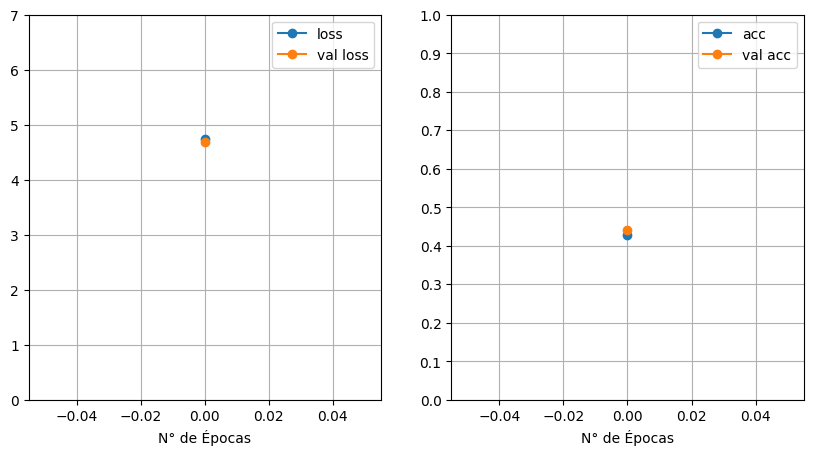

In [10]:
import matplotlib.pyplot as plt

# Plot Training
loss,val_loss,acc,val_acc = history_

epochs = np.arange(len(loss))
fig = plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(epochs,loss, '-o', label="loss")
plt.plot(epochs,val_loss, '-o', label="val loss")
plt.xlabel("N° de Épocas")
plt.yticks(np.arange(0,8,1))
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs,acc, '-o', label="acc")
plt.plot(epochs,val_acc, '-o', label="val acc")
plt.xlabel("N° de Épocas")
plt.yticks(np.arange(0,1.1,0.1))
plt.grid()
plt.legend()

## Testing

In [11]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │      2,352 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 37, 37,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 19, 19,    │      2,304 │ max_pooling2d[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 19, 19,    │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 19, 19,    │      2,304 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 19, 19,    │         64 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 19, 19,    │          0 │ batch_normalizat… │
│                     │ 16)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 19, 19,    │      2,304 │ add[0][0]         │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 19, 19,    │         64 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 19, 19,    │          0 │ add[0][0],        │
│                     │ 16)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 10, 10,    │      4,608 │ add_1[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 10,    │        128 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 10, 10,    │      9,216 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 10,    │        128 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 10, 10,    │          0 │ batch_normalizat

 Total params: 17,471,890 (66.65 MB)

 Trainable params: 5,822,448 (22.21 MB)

 Non-trainable params: 4,544 (17.75 KB)

 Optimizer params: 11,644,898 (44.42 MB)

In [12]:
model.input_shape

(None, 224, 224, 3)

Query dog class: 1268
Query image: ../data/data/56/56.4.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


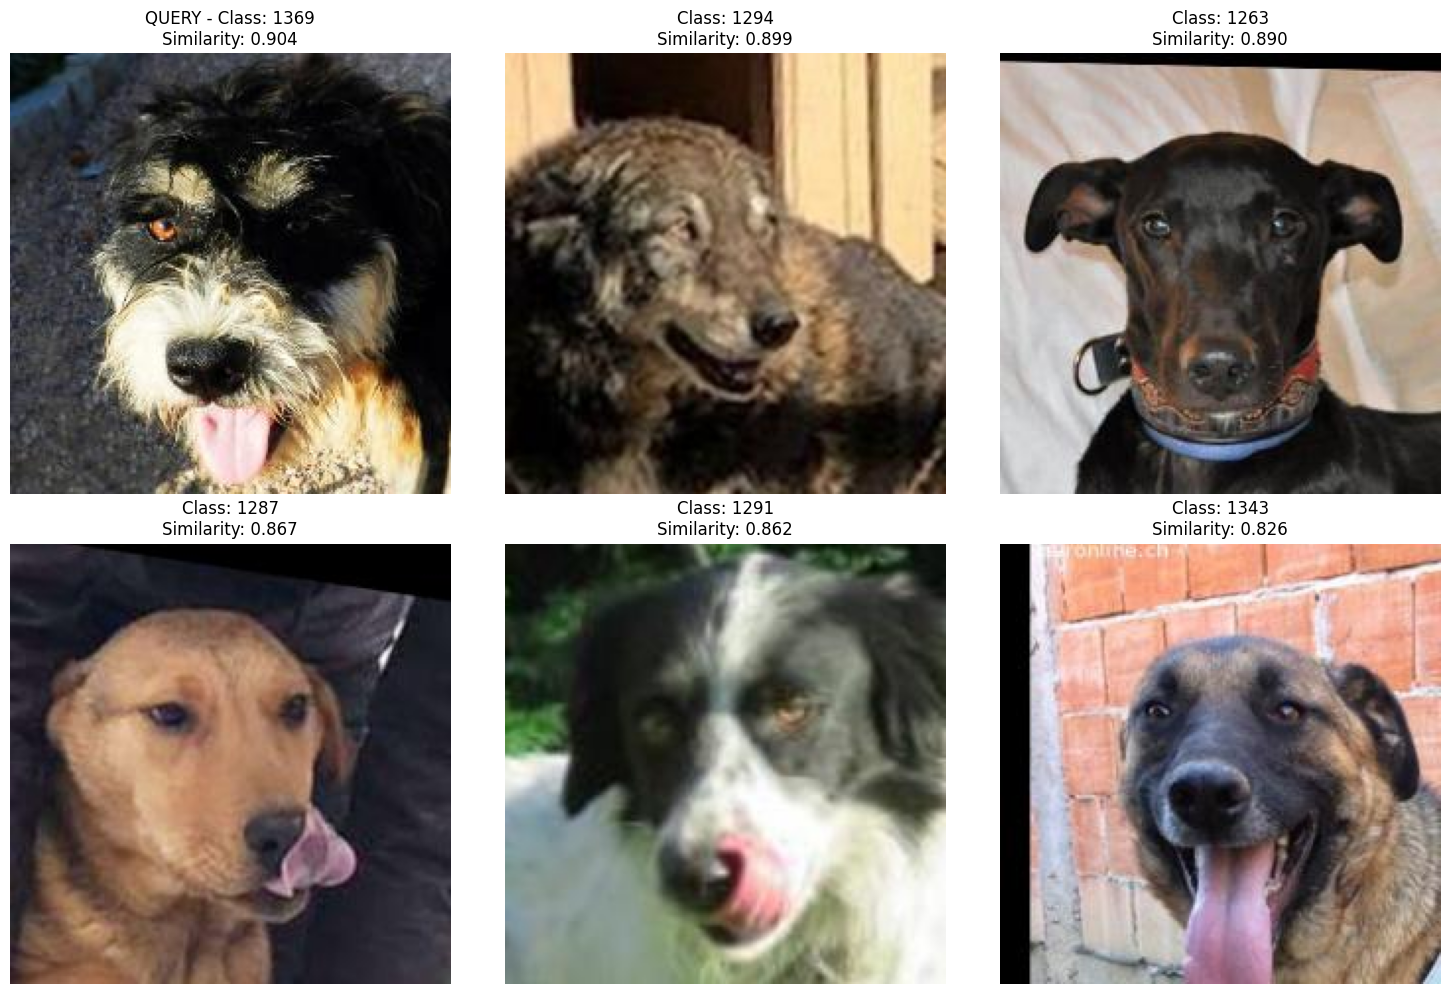

In [13]:
def preprocess_image(image_path, target_size=(224, 224)):
    """Preprocess image for model input"""
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=target_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    return img_array

# TODO: conectar com um banco de dados e carregar os embeddings de lá
def get_embeddings(reference_images, model):
    """Get embeddings for all reference images"""
    reference_embeddings = []
    for img_path in reference_images:
        ref_img = preprocess_image(img_path)
        ref_embedding = model.predict(ref_img, verbose=0)
        reference_embeddings.append(ref_embedding.flatten())
    
    reference_embeddings = np.array(reference_embeddings)

    return reference_embeddings

def find_most_similar_dog(query_image_path, reference_embeddings, model, top_k=5):
    """Find most similar dogs using cosine similarity on embeddings"""
    # Get embedding for query image
    query_img = preprocess_image(query_image_path)
    
    # # =================================    
    # plt.figure(figsize=(10, 8))
    # plt.imshow(query_img)
    # plt.axis('off')
    # plt.show()
    # #============================

    query_embedding = model.predict(query_img)

    # Calculate cosine similarity
    similarities = cosine_similarity(query_embedding, reference_embeddings)[0]
    
    # Get top-k most similar
    top_indices = np.argsort(similarities)[-top_k:][::-1]
    
    return top_indices, similarities[top_indices]

    # return None, None

# Seleciona uma imagem aleatoria de teste
query_idx = np.random.randint(0, len(filenames_test))
query_image = filenames_test[query_idx]
query_label = labels_test[query_idx]

print(f"Query dog class: {int(query_label)}")
print(f"Query image: {query_image}")

# TODO: Salvar os embeddings em um banco de dados
reference_indices = np.arange(len(filenames_test))
reference_indices = reference_indices[reference_indices != query_idx]
reference_images = filenames_test[reference_indices]

reference_embeddings = get_embeddings(reference_images, model)

# Busca o embedding mais similar
top_indices, similarities = find_most_similar_dog(
    query_image, 
    reference_embeddings,
    model, 
    top_k=6
)

# Mostra os cachorros mais semelhantes encontrados
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, (idx, similarity) in enumerate(zip(top_indices, similarities)):
    img_path = filenames_test[idx]
    img_label = labels_test[idx]
    
    img = Image.open(img_path)
    axes[i].imshow(img)
    
    title = f"Class: {int(img_label)}\nSimilarity: {similarity:.3f}"
    if i == 0:
        title = f"QUERY - {title}"
    
    axes[i].set_title(title)
    axes[i].axis('off')

plt.tight_layout()
plt.show()